## Fixed Data:

In [1]:
pip install fredapi 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from fredapi import Fred


API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'TransactionCount': '/v1/metrics/transactions/count',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

## Get Multiple Attributes for Multiple Coins:

### Define a function to pull attributes, input coin type and attribute

In [3]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    print(f"Pulling {coin}'s {feature}")

    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

### Input a coin list, it will output all defined attributes

In [4]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from tqdm import tqdm
    from fredapi import Fred

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Data Pull
    for i in tqdm(coinList):
        print(f"Start Pulling {i}'s data:")

        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Get data
        for j in list(endPoints.keys()):
            locals()[frameName].append(PullData(i,
                                                j))

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             how='left',
                                                             on='Date').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                                     ignore_index=True)

        print(f"{i} data successfully pulled\n")
    print('All Frames Merged')
    print('\nALL DATA SUCCESSFULLY PULLED!')

    return fullFrame

## <font color='green'> Added : Imputation for NA values using linear interpolation method
if the price for the asset is missing for the latest **4 weeks** , then we consider it as a cryto currency that stopped trading, we won't include it in our sample


In [129]:
def InterpolationImpute (sample: pd.DataFrame):
    """This Method will impute NA values using linear interpolation method

    Args:
        sample (pd.DataFrame): The Pulled Data 

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Imputed all NA using linear interpolation
    """
    # Initialization
    imputedFrame = pd.DataFrame(columns=list(sample.columns))
    
    orgcols = list(sample.columns)
    cols = orgcols.copy()
    cols.remove('Date')
    cols.remove('Asset')
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)

#if the price for the asset is missing for the latest **4 weeks** , 
#then we consider it as a cryto currency that stopped trading, we won't include it in our sample

        if (segment['Price'][-4:].isnull().sum() < 4):
            temp = segment[cols].interpolate(method='linear', limit_direction='forward', axis=0)
            temp['Asset'] = segment['Asset']
            temp['Date'] = segment['Date']
            imputedFrame = pd.concat([imputedFrame, temp[orgcols]],
                                     ignore_index=True)
    

    
    return imputedFrame

## Calculate the return - Now only pick lastest 52 records for testing
Input is a dataframe includes all pulled data

In [11]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns).append('Return'))
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
        # Only Select 53 Weeks for Test
        temp = segment[-53:-1].reset_index().drop('index', axis=1)
        segment = segment[-52:].reset_index().drop('index', axis=1)
        segment['Return'] = (segment['Price'] - temp['Price'])/temp['Price']
        fullFrame = pd.concat([fullFrame, segment],
                                     ignore_index=True)
    return fullFrame

## Initialize - get full sample

In [8]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

# Add Return to fullSample
fullSample_add = AddReturn(fullSample_raw)

# Impute missing value using interploration method
fullSample = InterpolationImpute(fullSample_add)



  0%|                                                   | 0/124 [00:00<?, ?it/s]

Start Pulling BTC's data:
Pulling BTC's Price
Pulling BTC's MarketCap
Pulling BTC's TransactionCount
Pulling BTC's ActiveAddress


  1%|▎                                          | 1/124 [00:01<03:26,  1.68s/it]

BTC data successfully pulled

Start Pulling ETH's data:
Pulling ETH's Price
Pulling ETH's MarketCap
Pulling ETH's TransactionCount
Pulling ETH's ActiveAddress


  2%|▋                                          | 2/124 [00:04<04:23,  2.16s/it]

ETH data successfully pulled

Start Pulling LTC's data:
Pulling LTC's Price
Pulling LTC's MarketCap
Pulling LTC's TransactionCount
Pulling LTC's ActiveAddress


  2%|█                                          | 3/124 [00:06<04:31,  2.24s/it]

LTC data successfully pulled

Start Pulling AAVE's data:
Pulling AAVE's Price
Pulling AAVE's MarketCap
Pulling AAVE's TransactionCount
Pulling AAVE's ActiveAddress


  3%|█▍                                         | 4/124 [00:07<03:47,  1.89s/it]

AAVE data successfully pulled

Start Pulling ABT's data:
Pulling ABT's Price
Pulling ABT's MarketCap
Pulling ABT's TransactionCount
Pulling ABT's ActiveAddress


  4%|█▋                                         | 5/124 [00:09<03:17,  1.66s/it]

ABT data successfully pulled

Start Pulling AMPL's data:
Pulling AMPL's Price
Pulling AMPL's MarketCap
Pulling AMPL's TransactionCount
Pulling AMPL's ActiveAddress


  5%|██                                         | 6/124 [00:10<03:15,  1.66s/it]

AMPL data successfully pulled

Start Pulling ANT's data:
Pulling ANT's Price
Pulling ANT's MarketCap
Pulling ANT's TransactionCount
Pulling ANT's ActiveAddress


  6%|██▍                                        | 7/124 [00:12<03:19,  1.71s/it]

ANT data successfully pulled

Start Pulling ARMOR's data:
Pulling ARMOR's Price
Pulling ARMOR's MarketCap
Pulling ARMOR's TransactionCount
Pulling ARMOR's ActiveAddress


  6%|██▊                                        | 8/124 [00:13<03:02,  1.57s/it]

ARMOR data successfully pulled

Start Pulling BADGER's data:
Pulling BADGER's Price
Pulling BADGER's MarketCap
Pulling BADGER's TransactionCount
Pulling BADGER's ActiveAddress


  7%|███                                        | 9/124 [00:15<02:58,  1.55s/it]

BADGER data successfully pulled

Start Pulling BAL's data:
Pulling BAL's Price
Pulling BAL's MarketCap
Pulling BAL's TransactionCount
Pulling BAL's ActiveAddress


  8%|███▍                                      | 10/124 [00:16<02:48,  1.48s/it]

BAL data successfully pulled

Start Pulling BAND's data:
Pulling BAND's Price
Pulling BAND's MarketCap
Pulling BAND's TransactionCount
Pulling BAND's ActiveAddress


  9%|███▋                                      | 11/124 [00:18<02:45,  1.46s/it]

BAND data successfully pulled

Start Pulling BAT's data:
Pulling BAT's Price
Pulling BAT's MarketCap
Pulling BAT's TransactionCount
Pulling BAT's ActiveAddress


 10%|████                                      | 12/124 [00:20<03:00,  1.61s/it]

BAT data successfully pulled

Start Pulling BIX's data:
Pulling BIX's Price
Pulling BIX's MarketCap
Pulling BIX's TransactionCount
Pulling BIX's ActiveAddress


 10%|████▍                                     | 13/124 [00:21<02:52,  1.55s/it]

BIX data successfully pulled

Start Pulling BNT's data:
Pulling BNT's Price
Pulling BNT's MarketCap
Pulling BNT's TransactionCount
Pulling BNT's ActiveAddress


 11%|████▋                                     | 14/124 [00:23<03:00,  1.64s/it]

BNT data successfully pulled

Start Pulling BOND's data:
Pulling BOND's Price
Pulling BOND's MarketCap
Pulling BOND's TransactionCount
Pulling BOND's ActiveAddress


 12%|█████                                     | 15/124 [00:24<02:43,  1.50s/it]

BOND data successfully pulled

Start Pulling BRD's data:
Pulling BRD's Price
Pulling BRD's MarketCap
Pulling BRD's TransactionCount
Pulling BRD's ActiveAddress


 13%|█████▍                                    | 16/124 [00:25<02:33,  1.42s/it]

BRD data successfully pulled

Start Pulling BUSD's data:
Pulling BUSD's Price
Pulling BUSD's MarketCap
Pulling BUSD's TransactionCount
Pulling BUSD's ActiveAddress


 14%|█████▊                                    | 17/124 [00:27<02:29,  1.40s/it]

BUSD data successfully pulled

Start Pulling BZRX's data:
Pulling BZRX's Price
Pulling BZRX's MarketCap
Pulling BZRX's TransactionCount
Pulling BZRX's ActiveAddress


 15%|██████                                    | 18/124 [00:28<02:29,  1.41s/it]

BZRX data successfully pulled

Start Pulling CELR's data:
Pulling CELR's Price
Pulling CELR's MarketCap
Pulling CELR's TransactionCount
Pulling CELR's ActiveAddress


 15%|██████▍                                   | 19/124 [00:31<03:04,  1.75s/it]

CELR data successfully pulled

Start Pulling CHSB's data:
Pulling CHSB's Price
Pulling CHSB's MarketCap
Pulling CHSB's TransactionCount
Pulling CHSB's ActiveAddress


 16%|██████▊                                   | 20/124 [00:32<03:03,  1.76s/it]

CHSB data successfully pulled

Start Pulling CND's data:
Pulling CND's Price
Pulling CND's MarketCap
Pulling CND's TransactionCount
Pulling CND's ActiveAddress


 17%|███████                                   | 21/124 [00:35<03:15,  1.89s/it]

CND data successfully pulled

Start Pulling COMP's data:
Pulling COMP's Price
Pulling COMP's MarketCap
Pulling COMP's TransactionCount
Pulling COMP's ActiveAddress


 18%|███████▍                                  | 22/124 [00:36<02:59,  1.76s/it]

COMP data successfully pulled

Start Pulling CREAM's data:
Pulling CREAM's Price
Pulling CREAM's MarketCap
Pulling CREAM's TransactionCount
Pulling CREAM's ActiveAddress


 19%|███████▊                                  | 23/124 [00:38<03:03,  1.81s/it]

CREAM data successfully pulled

Start Pulling CRO's data:
Pulling CRO's Price
Pulling CRO's MarketCap
Pulling CRO's TransactionCount
Pulling CRO's ActiveAddress


 19%|████████▏                                 | 24/124 [00:41<03:29,  2.09s/it]

CRO data successfully pulled

Start Pulling CRV's data:
Pulling CRV's Price
Pulling CRV's MarketCap
Pulling CRV's TransactionCount
Pulling CRV's ActiveAddress


 20%|████████▍                                 | 25/124 [00:43<03:24,  2.06s/it]

CRV data successfully pulled

Start Pulling CVC's data:
Pulling CVC's Price
Pulling CVC's MarketCap
Pulling CVC's TransactionCount
Pulling CVC's ActiveAddress


 21%|████████▊                                 | 26/124 [00:45<03:28,  2.13s/it]

CVC data successfully pulled

Start Pulling CVP's data:
Pulling CVP's Price
Pulling CVP's MarketCap
Pulling CVP's TransactionCount
Pulling CVP's ActiveAddress


 22%|█████████▏                                | 27/124 [00:47<03:30,  2.17s/it]

CVP data successfully pulled

Start Pulling DAI's data:
Pulling DAI's Price
Pulling DAI's MarketCap
Pulling DAI's TransactionCount
Pulling DAI's ActiveAddress


 23%|█████████▍                                | 28/124 [00:49<03:08,  1.96s/it]

DAI data successfully pulled

Start Pulling DDX's data:
Pulling DDX's Price
Pulling DDX's MarketCap
Pulling DDX's TransactionCount
Pulling DDX's ActiveAddress


 23%|█████████▊                                | 29/124 [00:50<02:54,  1.84s/it]

DDX data successfully pulled

Start Pulling DENT's data:
Pulling DENT's Price
Pulling DENT's MarketCap
Pulling DENT's TransactionCount
Pulling DENT's ActiveAddress


 24%|██████████▏                               | 30/124 [00:53<03:03,  1.96s/it]

DENT data successfully pulled

Start Pulling DGX's data:
Pulling DGX's Price
Pulling DGX's MarketCap
Pulling DGX's TransactionCount
Pulling DGX's ActiveAddress


 25%|██████████▌                               | 31/124 [00:55<03:30,  2.26s/it]

DGX data successfully pulled

Start Pulling DHT's data:
Pulling DHT's Price
Pulling DHT's MarketCap
Pulling DHT's TransactionCount
Pulling DHT's ActiveAddress


 26%|██████████▊                               | 32/124 [00:57<03:00,  1.97s/it]

DHT data successfully pulled

Start Pulling DMG's data:
Pulling DMG's Price
Pulling DMG's MarketCap
Pulling DMG's TransactionCount
Pulling DMG's ActiveAddress


 27%|███████████▏                              | 33/124 [00:58<02:45,  1.82s/it]

DMG data successfully pulled

Start Pulling DODO's data:
Pulling DODO's Price
Pulling DODO's MarketCap
Pulling DODO's TransactionCount
Pulling DODO's ActiveAddress


 27%|███████████▌                              | 34/124 [01:00<02:39,  1.77s/it]

DODO data successfully pulled

Start Pulling DOUGH's data:
Pulling DOUGH's Price
Pulling DOUGH's MarketCap
Pulling DOUGH's TransactionCount
Pulling DOUGH's ActiveAddress


 28%|███████████▊                              | 35/124 [01:01<02:29,  1.68s/it]

DOUGH data successfully pulled

Start Pulling DRGN's data:
Pulling DRGN's Price
Pulling DRGN's MarketCap
Pulling DRGN's TransactionCount
Pulling DRGN's ActiveAddress


 29%|████████████▏                             | 36/124 [01:03<02:21,  1.61s/it]

DRGN data successfully pulled

Start Pulling ELF's data:
Pulling ELF's Price
Pulling ELF's MarketCap
Pulling ELF's TransactionCount
Pulling ELF's ActiveAddress


 30%|████████████▌                             | 37/124 [01:05<02:42,  1.87s/it]

ELF data successfully pulled

Start Pulling ENG's data:
Pulling ENG's Price
Pulling ENG's MarketCap
Pulling ENG's TransactionCount
Pulling ENG's ActiveAddress


 31%|████████████▊                             | 38/124 [01:07<02:39,  1.86s/it]

ENG data successfully pulled

Start Pulling ENJ's data:
Pulling ENJ's Price
Pulling ENJ's MarketCap
Pulling ENJ's TransactionCount
Pulling ENJ's ActiveAddress


 31%|█████████████▏                            | 39/124 [01:09<02:38,  1.87s/it]

ENJ data successfully pulled

Start Pulling EURS's data:
Pulling EURS's Price
Pulling EURS's MarketCap
Pulling EURS's TransactionCount
Pulling EURS's ActiveAddress


 32%|█████████████▌                            | 40/124 [01:10<02:24,  1.72s/it]

EURS data successfully pulled

Start Pulling FET's data:
Pulling FET's Price
Pulling FET's MarketCap
Pulling FET's TransactionCount
Pulling FET's ActiveAddress


 33%|█████████████▉                            | 41/124 [01:14<03:12,  2.32s/it]

FET data successfully pulled

Start Pulling FTT's data:
Pulling FTT's Price
Pulling FTT's MarketCap
Pulling FTT's TransactionCount
Pulling FTT's ActiveAddress


 34%|██████████████▏                           | 42/124 [01:15<02:45,  2.02s/it]

FTT data successfully pulled

Start Pulling FUN's data:
Pulling FUN's Price
Pulling FUN's MarketCap
Pulling FUN's TransactionCount
Pulling FUN's ActiveAddress


 35%|██████████████▌                           | 43/124 [01:17<02:39,  1.97s/it]

FUN data successfully pulled

Start Pulling GNO's data:
Pulling GNO's Price
Pulling GNO's MarketCap
Pulling GNO's TransactionCount
Pulling GNO's ActiveAddress


 35%|██████████████▉                           | 44/124 [01:20<02:52,  2.15s/it]

GNO data successfully pulled

Start Pulling GUSD's data:
Pulling GUSD's Price
Pulling GUSD's MarketCap
Pulling GUSD's TransactionCount
Pulling GUSD's ActiveAddress


 36%|███████████████▏                          | 45/124 [01:21<02:34,  1.96s/it]

GUSD data successfully pulled

Start Pulling HEGIC's data:
Pulling HEGIC's Price
Pulling HEGIC's MarketCap
Pulling HEGIC's TransactionCount
Pulling HEGIC's ActiveAddress


 37%|███████████████▌                          | 46/124 [01:23<02:28,  1.91s/it]

HEGIC data successfully pulled

Start Pulling HOT's data:
Pulling HOT's Price
Pulling HOT's MarketCap
Pulling HOT's TransactionCount
Pulling HOT's ActiveAddress


 38%|███████████████▉                          | 47/124 [01:24<02:13,  1.73s/it]

HOT data successfully pulled

Start Pulling HPT's data:
Pulling HPT's Price
Pulling HPT's MarketCap
Pulling HPT's TransactionCount
Pulling HPT's ActiveAddress


 39%|████████████████▎                         | 48/124 [01:26<02:06,  1.66s/it]

HPT data successfully pulled

Start Pulling HT's data:
Pulling HT's Price
Pulling HT's MarketCap
Pulling HT's TransactionCount
Pulling HT's ActiveAddress


 40%|████████████████▌                         | 49/124 [01:28<02:13,  1.78s/it]

HT data successfully pulled

Start Pulling HUSD's data:
Pulling HUSD's Price
Pulling HUSD's MarketCap
Pulling HUSD's TransactionCount
Pulling HUSD's ActiveAddress


 40%|████████████████▉                         | 50/124 [01:29<02:00,  1.63s/it]

HUSD data successfully pulled

Start Pulling INDEX's data:
Pulling INDEX's Price
Pulling INDEX's MarketCap
Pulling INDEX's TransactionCount
Pulling INDEX's ActiveAddress


 41%|█████████████████▎                        | 51/124 [01:31<01:53,  1.56s/it]

INDEX data successfully pulled

Start Pulling KCS's data:
Pulling KCS's Price
Pulling KCS's MarketCap
Pulling KCS's TransactionCount
Pulling KCS's ActiveAddress


 42%|█████████████████▌                        | 52/124 [01:32<01:49,  1.52s/it]

KCS data successfully pulled

Start Pulling LAMB's data:
Pulling LAMB's Price
Pulling LAMB's MarketCap
Pulling LAMB's TransactionCount
Pulling LAMB's ActiveAddress


 43%|█████████████████▉                        | 53/124 [01:34<01:52,  1.59s/it]

LAMB data successfully pulled

Start Pulling LBA's data:
Pulling LBA's Price
Pulling LBA's MarketCap
Pulling LBA's TransactionCount
Pulling LBA's ActiveAddress


 44%|██████████████████▎                       | 54/124 [01:35<01:42,  1.46s/it]

LBA data successfully pulled

Start Pulling LDO's data:
Pulling LDO's Price
Pulling LDO's MarketCap
Pulling LDO's TransactionCount
Pulling LDO's ActiveAddress


 44%|██████████████████▋                       | 55/124 [01:36<01:40,  1.45s/it]

LDO data successfully pulled

Start Pulling LEO's data:
Pulling LEO's Price
Pulling LEO's MarketCap
Pulling LEO's TransactionCount
Pulling LEO's ActiveAddress


 45%|██████████████████▉                       | 56/124 [01:38<01:36,  1.42s/it]

LEO data successfully pulled

Start Pulling LINK's data:
Pulling LINK's Price
Pulling LINK's MarketCap
Pulling LINK's TransactionCount
Pulling LINK's ActiveAddress


 46%|███████████████████▎                      | 57/124 [01:39<01:37,  1.46s/it]

LINK data successfully pulled

Start Pulling LOOM's data:
Pulling LOOM's Price
Pulling LOOM's MarketCap
Pulling LOOM's TransactionCount
Pulling LOOM's ActiveAddress


 47%|███████████████████▋                      | 58/124 [01:42<02:00,  1.82s/it]

LOOM data successfully pulled

Start Pulling LRC's data:
Pulling LRC's Price
Pulling LRC's MarketCap
Pulling LRC's TransactionCount
Pulling LRC's ActiveAddress


 48%|███████████████████▉                      | 59/124 [01:44<01:52,  1.74s/it]

LRC data successfully pulled

Start Pulling MANA's data:
Pulling MANA's Price
Pulling MANA's MarketCap
Pulling MANA's TransactionCount
Pulling MANA's ActiveAddress


 48%|████████████████████▎                     | 60/124 [01:46<02:08,  2.01s/it]

MANA data successfully pulled

Start Pulling MATIC's data:
Pulling MATIC's Price
Pulling MATIC's MarketCap
Pulling MATIC's TransactionCount
Pulling MATIC's ActiveAddress


 49%|████████████████████▋                     | 61/124 [01:48<02:01,  1.93s/it]

MATIC data successfully pulled

Start Pulling MCB's data:
Pulling MCB's Price
Pulling MCB's MarketCap
Pulling MCB's TransactionCount
Pulling MCB's ActiveAddress


 50%|█████████████████████                     | 62/124 [01:49<01:49,  1.77s/it]

MCB data successfully pulled

Start Pulling MCO's data:
Pulling MCO's Price
Pulling MCO's MarketCap
Pulling MCO's TransactionCount
Pulling MCO's ActiveAddress


 51%|█████████████████████▎                    | 63/124 [01:51<01:38,  1.61s/it]

MCO data successfully pulled

Start Pulling MFT's data:
Pulling MFT's Price
Pulling MFT's MarketCap
Pulling MFT's TransactionCount
Pulling MFT's ActiveAddress


 52%|█████████████████████▋                    | 64/124 [01:53<01:49,  1.82s/it]

MFT data successfully pulled

Start Pulling MIR's data:
Pulling MIR's Price
Pulling MIR's MarketCap
Pulling MIR's TransactionCount
Pulling MIR's ActiveAddress


 52%|██████████████████████                    | 65/124 [01:55<01:46,  1.80s/it]

MIR data successfully pulled

Start Pulling MKR's data:
Pulling MKR's Price
Pulling MKR's MarketCap
Pulling MKR's TransactionCount
Pulling MKR's ActiveAddress


 53%|██████████████████████▎                   | 66/124 [01:56<01:35,  1.64s/it]

MKR data successfully pulled

Start Pulling MLN's data:
Pulling MLN's Price
Pulling MLN's MarketCap
Pulling MLN's TransactionCount
Pulling MLN's ActiveAddress


 54%|██████████████████████▋                   | 67/124 [01:57<01:27,  1.53s/it]

MLN data successfully pulled

Start Pulling MTA's data:
Pulling MTA's Price
Pulling MTA's MarketCap
Pulling MTA's TransactionCount
Pulling MTA's ActiveAddress


 55%|███████████████████████                   | 68/124 [01:59<01:23,  1.49s/it]

MTA data successfully pulled

Start Pulling MTL's data:
Pulling MTL's Price
Pulling MTL's MarketCap
Pulling MTL's TransactionCount
Pulling MTL's ActiveAddress


 56%|███████████████████████▎                  | 69/124 [02:00<01:18,  1.43s/it]

MTL data successfully pulled

Start Pulling MX's data:
Pulling MX's Price
Pulling MX's MarketCap
Pulling MX's TransactionCount
Pulling MX's ActiveAddress


 56%|███████████████████████▋                  | 70/124 [02:01<01:14,  1.39s/it]

MX data successfully pulled

Start Pulling NDX's data:
Pulling NDX's Price
Pulling NDX's MarketCap
Pulling NDX's TransactionCount
Pulling NDX's ActiveAddress


 57%|████████████████████████                  | 71/124 [02:02<01:11,  1.35s/it]

NDX data successfully pulled

Start Pulling NEXO's data:
Pulling NEXO's Price
Pulling NEXO's MarketCap
Pulling NEXO's TransactionCount
Pulling NEXO's ActiveAddress


 58%|████████████████████████▍                 | 72/124 [02:04<01:07,  1.30s/it]

NEXO data successfully pulled

Start Pulling NFTX's data:
Pulling NFTX's Price
Pulling NFTX's MarketCap
Pulling NFTX's TransactionCount
Pulling NFTX's ActiveAddress


 59%|████████████████████████▋                 | 73/124 [02:05<01:05,  1.28s/it]

NFTX data successfully pulled

Start Pulling NMR's data:
Pulling NMR's Price
Pulling NMR's MarketCap
Pulling NMR's TransactionCount
Pulling NMR's ActiveAddress


 60%|█████████████████████████                 | 74/124 [02:06<01:07,  1.35s/it]

NMR data successfully pulled

Start Pulling Nsure's data:
Pulling Nsure's Price
Pulling Nsure's MarketCap
Pulling Nsure's TransactionCount
Pulling Nsure's ActiveAddress


 60%|█████████████████████████▍                | 75/124 [02:08<01:04,  1.31s/it]

Nsure data successfully pulled

Start Pulling OCEAN's data:
Pulling OCEAN's Price
Pulling OCEAN's MarketCap
Pulling OCEAN's TransactionCount
Pulling OCEAN's ActiveAddress


 61%|█████████████████████████▋                | 76/124 [02:09<01:02,  1.30s/it]

OCEAN data successfully pulled

Start Pulling OKB's data:
Pulling OKB's Price
Pulling OKB's MarketCap
Pulling OKB's TransactionCount
Pulling OKB's ActiveAddress


 62%|██████████████████████████                | 77/124 [02:11<01:07,  1.43s/it]

OKB data successfully pulled

Start Pulling OMG's data:
Pulling OMG's Price
Pulling OMG's MarketCap
Pulling OMG's TransactionCount
Pulling OMG's ActiveAddress


 63%|██████████████████████████▍               | 78/124 [02:12<01:04,  1.40s/it]

OMG data successfully pulled

Start Pulling PAY's data:
Pulling PAY's Price
Pulling PAY's MarketCap
Pulling PAY's TransactionCount
Pulling PAY's ActiveAddress


 64%|██████████████████████████▊               | 79/124 [02:13<01:04,  1.43s/it]

PAY data successfully pulled

Start Pulling PERP's data:
Pulling PERP's Price
Pulling PERP's MarketCap
Pulling PERP's TransactionCount
Pulling PERP's ActiveAddress


 65%|███████████████████████████               | 80/124 [02:15<01:04,  1.47s/it]

PERP data successfully pulled

Start Pulling PICKLE's data:
Pulling PICKLE's Price
Pulling PICKLE's MarketCap
Pulling PICKLE's TransactionCount
Pulling PICKLE's ActiveAddress


 65%|███████████████████████████▍              | 81/124 [02:17<01:11,  1.65s/it]

PICKLE data successfully pulled

Start Pulling PNK's data:
Pulling PNK's Price
Pulling PNK's MarketCap
Pulling PNK's TransactionCount
Pulling PNK's ActiveAddress


 66%|███████████████████████████▊              | 82/124 [02:19<01:12,  1.72s/it]

PNK data successfully pulled

Start Pulling PNT's data:
Pulling PNT's Price
Pulling PNT's MarketCap
Pulling PNT's TransactionCount
Pulling PNT's ActiveAddress


 67%|████████████████████████████              | 83/124 [02:20<01:03,  1.56s/it]

PNT data successfully pulled

Start Pulling POLY's data:
Pulling POLY's Price
Pulling POLY's MarketCap
Pulling POLY's TransactionCount
Pulling POLY's ActiveAddress


 68%|████████████████████████████▍             | 84/124 [02:21<00:59,  1.49s/it]

POLY data successfully pulled

Start Pulling POWR's data:
Pulling POWR's Price
Pulling POWR's MarketCap
Pulling POWR's TransactionCount
Pulling POWR's ActiveAddress


 69%|████████████████████████████▊             | 85/124 [02:23<01:01,  1.58s/it]

POWR data successfully pulled

Start Pulling PPT's data:
Pulling PPT's Price
Pulling PPT's MarketCap
Pulling PPT's TransactionCount
Pulling PPT's ActiveAddress


 69%|█████████████████████████████▏            | 86/124 [02:24<00:55,  1.47s/it]

PPT data successfully pulled

Start Pulling QASH's data:
Pulling QASH's Price
Pulling QASH's MarketCap
Pulling QASH's TransactionCount
Pulling QASH's ActiveAddress


 70%|█████████████████████████████▍            | 87/124 [02:28<01:12,  1.97s/it]

QASH data successfully pulled

Start Pulling QKC's data:
Pulling QKC's Price
Pulling QKC's MarketCap
Pulling QKC's TransactionCount
Pulling QKC's ActiveAddress


 71%|█████████████████████████████▊            | 88/124 [02:29<01:03,  1.77s/it]

QKC data successfully pulled

Start Pulling QNT's data:
Pulling QNT's Price
Pulling QNT's MarketCap
Pulling QNT's TransactionCount
Pulling QNT's ActiveAddress


 72%|██████████████████████████████▏           | 89/124 [02:31<01:01,  1.76s/it]

QNT data successfully pulled

Start Pulling RDN's data:
Pulling RDN's Price
Pulling RDN's MarketCap
Pulling RDN's TransactionCount
Pulling RDN's ActiveAddress


 73%|██████████████████████████████▍           | 90/124 [02:32<00:57,  1.70s/it]

RDN data successfully pulled

Start Pulling REN's data:
Pulling REN's Price
Pulling REN's MarketCap
Pulling REN's TransactionCount
Pulling REN's ActiveAddress


 73%|██████████████████████████████▊           | 91/124 [02:34<00:56,  1.70s/it]

REN data successfully pulled

Start Pulling REP's data:
Pulling REP's Price
Pulling REP's MarketCap
Pulling REP's TransactionCount
Pulling REP's ActiveAddress


 74%|███████████████████████████████▏          | 92/124 [02:36<00:59,  1.86s/it]

REP data successfully pulled

Start Pulling RLC's data:
Pulling RLC's Price
Pulling RLC's MarketCap
Pulling RLC's TransactionCount
Pulling RLC's ActiveAddress


 75%|███████████████████████████████▌          | 93/124 [02:38<00:54,  1.77s/it]

RLC data successfully pulled

Start Pulling ROOK's data:
Pulling ROOK's Price
Pulling ROOK's MarketCap
Pulling ROOK's TransactionCount
Pulling ROOK's ActiveAddress


 76%|███████████████████████████████▊          | 94/124 [02:39<00:47,  1.58s/it]

ROOK data successfully pulled

Start Pulling RPL's data:
Pulling RPL's Price
Pulling RPL's MarketCap
Pulling RPL's TransactionCount
Pulling RPL's ActiveAddress


 77%|████████████████████████████████▏         | 95/124 [02:40<00:43,  1.50s/it]

RPL data successfully pulled

Start Pulling RSR's data:
Pulling RSR's Price
Pulling RSR's MarketCap
Pulling RSR's TransactionCount
Pulling RSR's ActiveAddress


 77%|████████████████████████████████▌         | 96/124 [02:41<00:40,  1.43s/it]

RSR data successfully pulled

Start Pulling SAI's data:
Pulling SAI's Price
Pulling SAI's MarketCap
Pulling SAI's TransactionCount
Pulling SAI's ActiveAddress


 78%|████████████████████████████████▊         | 97/124 [02:43<00:39,  1.44s/it]

SAI data successfully pulled

Start Pulling SAN's data:
Pulling SAN's Price
Pulling SAN's MarketCap
Pulling SAN's TransactionCount
Pulling SAN's ActiveAddress


 79%|█████████████████████████████████▏        | 98/124 [02:45<00:43,  1.69s/it]

SAN data successfully pulled

Start Pulling SNT's data:
Pulling SNT's Price
Pulling SNT's MarketCap
Pulling SNT's TransactionCount
Pulling SNT's ActiveAddress


 80%|█████████████████████████████████▌        | 99/124 [02:47<00:40,  1.62s/it]

SNT data successfully pulled

Start Pulling SNX's data:
Pulling SNX's Price
Pulling SNX's MarketCap
Pulling SNX's TransactionCount
Pulling SNX's ActiveAddress


 81%|█████████████████████████████████        | 100/124 [02:48<00:36,  1.53s/it]

SNX data successfully pulled

Start Pulling STAKE's data:
Pulling STAKE's Price
Pulling STAKE's MarketCap
Pulling STAKE's TransactionCount
Pulling STAKE's ActiveAddress


 81%|█████████████████████████████████▍       | 101/124 [02:49<00:33,  1.47s/it]

STAKE data successfully pulled

Start Pulling STORJ's data:
Pulling STORJ's Price
Pulling STORJ's MarketCap
Pulling STORJ's TransactionCount
Pulling STORJ's ActiveAddress


 82%|█████████████████████████████████▋       | 102/124 [02:50<00:30,  1.39s/it]

STORJ data successfully pulled

Start Pulling sUSD's data:
Pulling sUSD's Price
Pulling sUSD's MarketCap
Pulling sUSD's TransactionCount
Pulling sUSD's ActiveAddress


 83%|██████████████████████████████████       | 103/124 [02:52<00:28,  1.34s/it]

sUSD data successfully pulled

Start Pulling SUSHI's data:
Pulling SUSHI's Price
Pulling SUSHI's MarketCap
Pulling SUSHI's TransactionCount
Pulling SUSHI's ActiveAddress


 84%|██████████████████████████████████▍      | 104/124 [02:53<00:25,  1.29s/it]

SUSHI data successfully pulled

Start Pulling TEL's data:
Pulling TEL's Price
Pulling TEL's MarketCap
Pulling TEL's TransactionCount
Pulling TEL's ActiveAddress


 85%|██████████████████████████████████▋      | 105/124 [02:54<00:24,  1.27s/it]

TEL data successfully pulled

Start Pulling TOP's data:
Pulling TOP's Price
Pulling TOP's MarketCap
Pulling TOP's TransactionCount
Pulling TOP's ActiveAddress


 85%|███████████████████████████████████      | 106/124 [02:55<00:22,  1.27s/it]

TOP data successfully pulled

Start Pulling UBT's data:
Pulling UBT's Price
Pulling UBT's MarketCap
Pulling UBT's TransactionCount
Pulling UBT's ActiveAddress


 86%|███████████████████████████████████▍     | 107/124 [02:57<00:21,  1.29s/it]

UBT data successfully pulled

Start Pulling UMA's data:
Pulling UMA's Price
Pulling UMA's MarketCap
Pulling UMA's TransactionCount
Pulling UMA's ActiveAddress


 87%|███████████████████████████████████▋     | 108/124 [02:58<00:20,  1.27s/it]

UMA data successfully pulled

Start Pulling UNI's data:
Pulling UNI's Price
Pulling UNI's MarketCap
Pulling UNI's TransactionCount
Pulling UNI's ActiveAddress


 88%|████████████████████████████████████     | 109/124 [03:00<00:20,  1.37s/it]

UNI data successfully pulled

Start Pulling USDC's data:
Pulling USDC's Price
Pulling USDC's MarketCap
Pulling USDC's TransactionCount
Pulling USDC's ActiveAddress


 89%|████████████████████████████████████▎    | 110/124 [03:01<00:19,  1.42s/it]

USDC data successfully pulled

Start Pulling USDK's data:
Pulling USDK's Price
Pulling USDK's MarketCap
Pulling USDK's TransactionCount
Pulling USDK's ActiveAddress


 90%|████████████████████████████████████▋    | 111/124 [03:03<00:20,  1.54s/it]

USDK data successfully pulled

Start Pulling USDP's data:
Pulling USDP's Price
Pulling USDP's MarketCap
Pulling USDP's TransactionCount
Pulling USDP's ActiveAddress


 90%|█████████████████████████████████████    | 112/124 [03:05<00:20,  1.75s/it]

USDP data successfully pulled

Start Pulling USDT's data:
Pulling USDT's Price
Pulling USDT's MarketCap
Pulling USDT's TransactionCount
Pulling USDT's ActiveAddress


 91%|█████████████████████████████████████▎   | 113/124 [03:06<00:17,  1.59s/it]

USDT data successfully pulled

Start Pulling UTK's data:
Pulling UTK's Price
Pulling UTK's MarketCap
Pulling UTK's TransactionCount
Pulling UTK's ActiveAddress


 92%|█████████████████████████████████████▋   | 114/124 [03:08<00:16,  1.63s/it]

UTK data successfully pulled

Start Pulling VERI's data:
Pulling VERI's Price
Pulling VERI's MarketCap
Pulling VERI's TransactionCount
Pulling VERI's ActiveAddress


 93%|██████████████████████████████████████   | 115/124 [03:10<00:14,  1.64s/it]

VERI data successfully pulled

Start Pulling WaBi's data:
Pulling WaBi's Price
Pulling WaBi's MarketCap
Pulling WaBi's TransactionCount
Pulling WaBi's ActiveAddress


 94%|██████████████████████████████████████▎  | 116/124 [03:13<00:18,  2.27s/it]

WaBi data successfully pulled

Start Pulling WAX's data:
Pulling WAX's Price
Pulling WAX's MarketCap
Pulling WAX's TransactionCount
Pulling WAX's ActiveAddress


 94%|██████████████████████████████████████▋  | 117/124 [03:16<00:16,  2.30s/it]

WAX data successfully pulled

Start Pulling WBTC's data:
Pulling WBTC's Price
Pulling WBTC's MarketCap
Pulling WBTC's TransactionCount
Pulling WBTC's ActiveAddress


 95%|███████████████████████████████████████  | 118/124 [03:17<00:11,  1.98s/it]

WBTC data successfully pulled

Start Pulling WETH's data:
Pulling WETH's Price
Pulling WETH's MarketCap
Pulling WETH's TransactionCount
Pulling WETH's ActiveAddress


 96%|███████████████████████████████████████▎ | 119/124 [03:19<00:09,  1.84s/it]

WETH data successfully pulled

Start Pulling wNXM's data:
Pulling wNXM's Price
Pulling wNXM's MarketCap
Pulling wNXM's TransactionCount
Pulling wNXM's ActiveAddress


 97%|███████████████████████████████████████▋ | 120/124 [03:20<00:06,  1.64s/it]

wNXM data successfully pulled

Start Pulling WTC's data:
Pulling WTC's Price
Pulling WTC's MarketCap
Pulling WTC's TransactionCount
Pulling WTC's ActiveAddress


 98%|████████████████████████████████████████ | 121/124 [03:21<00:04,  1.59s/it]

WTC data successfully pulled

Start Pulling YAM's data:
Pulling YAM's Price
Pulling YAM's MarketCap
Pulling YAM's TransactionCount
Pulling YAM's ActiveAddress


 98%|████████████████████████████████████████▎| 122/124 [03:22<00:02,  1.48s/it]

YAM data successfully pulled

Start Pulling YFI's data:
Pulling YFI's Price
Pulling YFI's MarketCap
Pulling YFI's TransactionCount
Pulling YFI's ActiveAddress


 99%|████████████████████████████████████████▋| 123/124 [03:24<00:01,  1.43s/it]

YFI data successfully pulled

Start Pulling ZRX's data:
Pulling ZRX's Price
Pulling ZRX's MarketCap
Pulling ZRX's TransactionCount
Pulling ZRX's ActiveAddress


100%|█████████████████████████████████████████| 124/124 [03:25<00:00,  1.66s/it]

ZRX data successfully pulled

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!


In [132]:
fullSample_add.isnull().sum()

Date                  0
Price               122
MarketCap             0
TransactionCount     49
ActiveAddress         0
RiskFree            744
Asset                 0
Return              122
dtype: int64

In [134]:
fullSample.isnull().sum() ## after imputation, note: already removed coins stopped trading

Date                0
Price               0
MarketCap           0
TransactionCount    0
ActiveAddress       0
RiskFree            0
Asset               0
Return              0
dtype: int64

## 1.MKT 
### 1.1Get the large capitalization portfolio - largeCapSample
Use (maket cap > 1m and top 100) to set up market porfolio

In [135]:
largeCapport = fullSample.query("MarketCap > 1000000")
largeCapSample = largeCapport.groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

In [136]:
largeCapSample.isnull().sum()

Date                0
Price               0
MarketCap           0
TransactionCount    0
ActiveAddress       0
RiskFree            0
Asset               0
Return              0
dtype: int64

### 1.2 Calculate MKT for each week

In [138]:
## largeCapSample is a big dataframe include all crypto currencies makcap greater than 1000000
marketport = largeCapSample.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

marketInd = largeCapSample.copy()
marketInd['weights'] = marketInd['Return'] * marketInd['MarketCap']
recomp = marketInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')
marketport['MarketIndexReturn'] = recomp['TotalMarketReturn']/ marketport['TotalMarketCap']

In [139]:
riskfree = largeCapSample.groupby('Date')['RiskFree'].mean().reset_index()
marketport = marketport.merge(riskfree, on='Date')
marketport['MKT'] = marketport['MarketIndexReturn'] - marketport['RiskFree']
MKT_f = marketport[['Date','MKT']]

In [140]:
MKT_f.head()

,Date,MKT
0,2021-05-03,0.118304
1,2021-05-10,-0.145881
2,2021-05-17,-0.280399
3,2021-05-24,0.069425
4,2021-05-31,0.042021


In [141]:
len(largeCapSample.Asset.unique())

108

In [142]:
len(fullSample.Asset.unique())

121

## 2. Calculate Size - SMB (currently use full sample)

### largeCap includes all the cryptos in the top cap 20%, smallCap includes all the cryptos in the bottom cap 20%

In [143]:
largeCap = fullSample.groupby(['Date']).apply(lambda 
                                                x: x.nlargest(round(0.2*len(symbolList)),
                                                              ['MarketCap'])).reset_index(drop=True)

smallCap = fullSample.groupby(['Date']).apply(lambda 
                                                x: x.nsmallest(round(0.2*len(symbolList)),
                                                              ['MarketCap'])).reset_index(drop=True)
largeCap.head()

,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Asset,Return
0,2021-05-03,58218.566077,1.088991e+12,2038316.0,6622607.0,0.0002,BTC,0.028357
1,2021-05-03,3932.359246,4.554030e+11,10602184.0,3548128.0,0.0002,ETH,0.331870
2,2021-05-03,1.000026,5.372178e+10,0.0,576798.0,0.0002,USDT,0.000035
3,2021-05-03,385.704466,2.608153e+10,882361.0,1438322.0,0.0002,LTC,0.433524
4,2021-05-03,52.096533,2.182895e+10,0.0,65705.0,0.0002,LINK,0.320233


In [144]:
len(largeCap.Asset.unique().sum())

122

### <font color = 'green'> Method 1: using value weighted method

In [145]:
largeInd = largeCap.copy()
largeport = largeCap.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

largeInd['weights'] = largeInd['Return'] * largeInd['MarketCap']

temp = largeInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')

largeport['LargePortReturn'] = temp['TotalMarketReturn']/ largeport['TotalMarketCap']

In [146]:
smallInd = smallCap.copy()
smallport = smallCap.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

smallInd['weights'] = smallInd['Return'] * smallInd['MarketCap']

temp = smallInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')

smallport['SmallPortReturn'] = temp['TotalMarketReturn']/ smallport['TotalMarketCap']

In [147]:
smallport['SMB'] = smallport['SmallPortReturn'] - largeport['LargePortReturn']
smb_f = smallport[['Date','SMB']]

In [148]:
smb_f.head()

,Date,SMB
0,2021-05-03,-0.065378
1,2021-05-10,-0.026721
2,2021-05-17,-0.215717
3,2021-05-24,0.066505
4,2021-05-31,0.036195


In [149]:
smallport.head()

,Date,TotalMarketCap,SmallPortReturn,SMB
0,2021-05-03,4.666271e+08,0.053903,-0.065378
1,2021-05-10,3.946338e+08,-0.172443,-0.026721
2,2021-05-17,2.200986e+08,-0.493379,-0.215717
3,2021-05-24,2.498192e+08,0.133241,0.066505
4,2021-05-31,2.693276e+08,0.076927,0.036195


### <font color = 'green'> Method 2: using equal weighted method

In [150]:
largeport2 = largeCap.groupby('Date')['Return'].mean().reset_index(name='LargePortReturn')
smallport2 = smallCap.groupby('Date')['Return'].mean().reset_index(name='SmallPortReturn')
smallport2['SMB'] = smallport2['SmallPortReturn'] - largeport2['LargePortReturn']
smb_f2 = smallport2[['Date','SMB']]

In [151]:
smb_f2.head()

,Date,SMB
0,2021-05-03,-0.168220
1,2021-05-10,-0.128466
2,2021-05-17,-0.104422
3,2021-05-24,-0.033261
4,2021-05-31,0.035372


## Linear Regression Model

### test for a single crypto currency

In [154]:
LTC_All = fullSample.query(" Asset == 'LTC' ")
ltc_reg = LTC_All[['Date','RiskFree','Return']]
mkt_smb = MKT_f.merge(smb_f, on = 'Date', how = 'outer')
ltc_reg = ltc_reg.merge(mkt_smb, on = 'Date', how = 'outer')

In [155]:
ltc_reg['ExcessReturn']=ltc_reg['Return'] - ltc_reg['RiskFree']
ltc_reg.head(5)

,Date,RiskFree,Return,MKT,SMB,ExcessReturn
0,2021-05-03,0.0002,0.433524,0.118304,-0.065378,0.433324
1,2021-05-10,0.0002,-0.231293,-0.145881,-0.026721,-0.231493
2,2021-05-17,0.0000,-0.513065,-0.280399,-0.215717,-0.513065
3,2021-05-24,0.0001,0.183915,0.069425,0.066505,0.183815
4,2021-05-31,0.0001,0.032219,0.042021,0.036195,0.032119


In [156]:
target = "ExcessReturn"
feature1 = ['MKT']
feature2 = ['SMB']
features =['MKT', 'SMB']

# features.remove(target)
# features.remove("Date")
y = ltc_reg[target].copy()
x1 = ltc_reg [feature1].copy()
x2 = ltc_reg [feature2].copy()
x3 = ltc_reg [features].copy()


In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

In [158]:
model1.fit(x1, y)
model2.fit(x2, y)
model3.fit(x3, y)

LinearRegression()

In [159]:
y1 = model1.predict(x1)
y2 = model2.predict(x2)
y3 = model3.predict(x3)

In [160]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def myPlot(factor, excessreturn, model):
    plt.scatter(factor, excessreturn, alpha=0.3)
    x = np.linspace(factor.min(), factor.max())
    y = model.predict(x.reshape(-1,1))
    plt.plot(x, y, color='r')
    plt.xlabel('factor')
    plt.ylabel('Excess Return')
    plt.title('Linear regression result for excess return and ONE factor')
    plt.show()

## Fator MKT vs Excess return

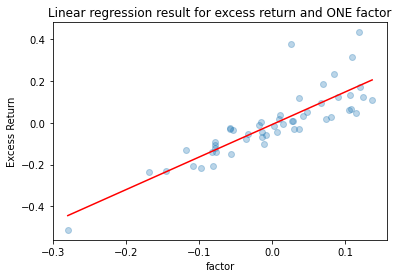

In [161]:
myPlot(ltc_reg.MKT, ltc_reg.ExcessReturn, model1)

In [162]:
### get the alpha with MKT factor only
print('alpha for LTC with MKT is:', model1.intercept_)

alpha for LTC with MKT is: -0.00763970274927746


In [163]:
### measure the performance of MKT Factor
print('MAS for MKT is {: .2e}'.format(mean_absolute_error(y, y1)))
print('MSE for MKT is {: .2e}'.format(mean_squared_error(y, y1)))
print('R2_score for MKT is {: .2f}'.format(r2_score(y, y1)))


MAS for MKT is  5.72e-02
MSE for MKT is  6.91e-03
R2_score for MKT is  0.72


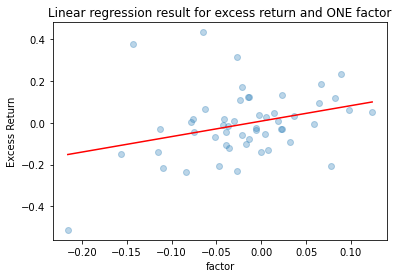

In [164]:
myPlot(ltc_reg.SMB, ltc_reg.ExcessReturn, model2)

In [165]:
print('MAS for SMB is {: .2e}'.format(mean_absolute_error(y, y2)))
print('MSE for SMB is {: .2e}'.format(mean_squared_error(y, y2)))
print('R2_score for SMB is {: .2f}'.format(r2_score(y, y2)))

MAS for SMB is  1.05e-01
MSE for SMB is  2.26e-02
R2_score for SMB is  0.10


In [166]:
### get the alpha with Size factor only
print('alpha for LTC with SMB is:', model2.intercept_)

alpha for LTC with SMB is: 0.007903948578665942


In [167]:
print('MAS for MKT combined with SMB is {: .2e}'.format(mean_absolute_error(y, y3)))
print('MSE for MKT combined with SMB is {: .2e}'.format(mean_squared_error(y, y3)))
print('R2_score for MKT combined with SMB is {: .2f}'.format(r2_score(y, y3)))

MAS for MKT combined with SMB is  5.82e-02
MSE for MKT combined with SMB is  6.89e-03
R2_score for MKT combined with SMB is  0.72


In [168]:
print('alpha for LTC with combination for MKT and SMB is:', model3.intercept_)

alpha for LTC with combination for MKT and SMB is: -0.009172916280296015


## Output a list of alphas for the top 10 crypto currencies using factors MKT & SMB

In [199]:
from sklearn.linear_model import LinearRegression
performance = {}
factors = MKT_f.merge(smb_f, on = 'Date', how = 'outer')  
features = factors.columns.tolist()
features.remove('Date')
target = "ExcessReturn"

#currently only generate alphas for those crypto currencies whose makcap > 1m and top 100 at the latest week
latest = largeCapSample.Date.max()
latestLarge = largeCapSample.query("Date == @latest")


for index in latestLarge['Asset'].unique().tolist():
    syntax = f"Asset == '{index}'"
    segment = fullSample.query(syntax)
    
    reg = segment[['Date','RiskFree','Return']].merge(factors, on = 'Date', how = 'outer')
    reg['ExcessReturn'] = reg['Return'] - reg['RiskFree']
    y = reg [target].copy()
    x = reg [features].copy()    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)    
    alpha = model.intercept_    
    performance[index] = alpha


In [224]:
##question: alpha, absolute value or just value?

alp_sig = pd.DataFrame(list(performance.items()), columns = ['Asset','Alpha'])
alp_sig = alp_sig.sort_values(by=['Alpha'])
alp_sig.head(10)



,Asset,Alpha
98,HEGIC,-0.031660
75,MIR,-0.017986
57,RSR,-0.017301
64,FUN,-0.014028
83,BOND,-0.013643
35,BNT,-0.012883
43,SUSHI,-0.011480
99,WaBi,-0.010667
13,UNI,-0.010221
85,DODO,-0.010127


## <font color='green'>Testing purpose : try to find the first date with available price

In [89]:
df = pd.DataFrame(columns = LTC_All.columns.values)
df['Asset'] = ''

for i in symbolList:
    
    dfName = f"{i}_All" 
    test=pd.DataFrame
    df1 = locals()[dfName][locals()[dfName].Price.notnull()].iloc[0]
    
    df1['Asset'] = i
    df=df.append(df1, ignore_index=True)

In [90]:
df.to_csv("firstavailable_price.csv")

In [108]:
new = df.sort_values(by=['Date'])

In [78]:
LTC_All.Price.loc[~LTC_All.Price.isnull()]

0        3.149100
1        3.150000
2        2.830000
3        2.348333
4        2.150000
          ...    
462    129.241438
463    128.926292
464    111.343007
465    109.018201
466    104.648982
Name: Price, Length: 467, dtype: float64